# Master Thesis: Wildfire Analysis Modelling

Author:
[Dominik Bursy](mailto:dominik.bursy@icloud.com)
 
Last Update: October 2022
 
---
 
The objective of this notebook is to run the empirical analysis.

---
 
## Table of Contents

- [Import Packages](#packages)
- [Set Color Scheme](#authentication)
- [Import & Prepare Data](#authentication)
- [1. Regression: Wildfire by Location Characteristics](#regression1)
- [2. Regression: Light Intensity, Elevation, Precipitation, Heat](#regression2)
- [3. Regression: Wildfire x Determinants](#regression3)
- [4. Regressions: Light x Wildfire Lags ](#regression4)
- [5. Regressions: Light x Wildfire Interaction Lags](#regression5)
- [6. Regressions: Change in Land Use](#regression6)
- [7. Regressions: Robustness IV](#regression7)

---

## Import Packages

In [108]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import time

import statsmodels.api as sm
from linearmodels import PanelOLS, PooledOLS, RandomEffects

import os
import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_columns', None)

## Set Color Scheme

In [2]:
sns.set_theme()
# https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#sns.set_theme(style="ticks", rc=custom_params, palette="Paired")
sns.set_theme(style="ticks", rc=custom_params)

# Create an array with the colors you want to use
colors = sns.color_palette("viridis", n_colors=2)
# colors = ["#3852A3", "#000000"]

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

## Import & Prepare Data

In [3]:
start_year = 2003
end_year   = 2008

In [4]:
## Import Data

raw_df = pd.read_pickle(
    os.path.join(os.path.dirname("__file__"), '..', 'data', 'final_gdf_025.zip')
)
#raw_df = raw_df.drop(columns=['geometry'])

In [5]:
## Subset Data Frame to Grids with Urban Extents

condition = (raw_df['grump_urban_indicator'] > 0)

# Alternatively Use Urban Settlement Definition
#condition = (raw_df['city_indicator'] > 0) & (raw_df['grump_urban_indicator'] > 0)

raw_df = raw_df[condition]

#print('Raw DataFrame Shape: ', raw_df.shape)
#print('Raw DataFrame Columns: ', raw_df.columns)

---

In [6]:
## Add Light 1992 as a regular variable
raw_df['ln_light1992'] = np.log(raw_df['light_1992']+1)
raw_df['light1992'] = raw_df['light_1992']
raw_df['ln_light2008'] = np.log(raw_df['light_2008']+1)
raw_df['light2012'] = raw_df['light_2012']
raw_df['ln_light2012'] = np.log(raw_df['light_2012']+1)

---

### Reshape Data Frame Wide Long

In [7]:
raw_df = raw_df.reset_index().rename(columns={'index':'grid_cell'})

In [8]:
## List Yearly Feature and Reshape Data Frame
yearly_features = ['burned_area_', 'count_', 'count_burned_area_', 'emissions_', 'precip_', 
                   'avg_temp_', 'duration_', 'light_',
                   'ocean_', 'urban_', 'cropland_', 'pasture_', 'forest_', 
                   'grass_shrubland_', 'sparse_', 'water_', 'no_data_']
raw_df_long = pd.wide_to_long(raw_df, yearly_features, i='grid_cell', j='grid_year')

## Rename Features
yearly_features_new = ['burned_area', 'count', 'count_burned_area', 'emissions', 'precip', 
                       'avg_temp', 'duration', 'light',
                       'ocean', 'urban', 'cropland', 'pasture', 'forest', 
                       'grass_shrubland', 'sparse', 'water', 'no_data']
raw_df_long = raw_df_long.rename(columns=dict(zip(yearly_features,yearly_features_new)))

## Create Year Variable
raw_df_long['year'] = raw_df_long.index.get_level_values('grid_year')

In [9]:
## Log Light & Create Lags
raw_df_long['ln_light'] = np.log(raw_df_long['light']+1)

raw_df_long['ln_light_lag1'] = raw_df_long['ln_light'].shift(1)
raw_df_long['ln_light_lag2'] = raw_df_long['ln_light'].shift(2)

raw_df_long['other_land'] = raw_df_long[['sparse', 'water', 'no_data']].sum(axis=1)

In [10]:
## Define Feature Lists to Show Origin

main_features = ['burned_area', 'count', 'count_burned_area', 'emissions', 'ln_light', 'light',
                 'light1992', 'ln_light1992', 'ln_light2008', 
                 'light2012', 'ln_light2012', 'ln_light_lag1', 'ln_light_lag2', 
                 'avg_temp', 'duration', 'elevation', 'elevation_min', 'elevation_max', 
                 'elevation_distance', 'precip', 'year', 'grid_cell_area', 'geometry']

landuse_features = ['urban', 'cropland', 'pasture', 'forest', 'grass_shrubland', 'other_land', 'ocean', 'water']

grump_urban_features = ['grump_urban_indicator', 'grump_URBID', 'grump_NAME', 'grump_Continent',
                        'grump_Countryeng', 'ES90POP', 'ES95POP', 'ES00POP']

##################################################

settlement_urban_features = ['city_indicator', 'Latlongid', 'Urborrur', 'Type', 'Name1', 'Admnm1', 'Country']

heat_urban_features = ['ID_HDC_G0', 'UC_NM_MN', 'CTR_MN_NM', 'region', 'sub-region', 'GCPNT_LAT', 'GCPNT_LON']

##################################################

---

### Subset Year

In [11]:
raw_df_subset = raw_df_long[main_features + landuse_features + grump_urban_features]

In [12]:
condition = (raw_df_subset['year'] >= start_year) & (raw_df_subset['year'] <= end_year+1)
raw_df_subset = raw_df_subset[condition]

condition1 = raw_df_subset['year'] != 2009
condition2 = raw_df_subset['year'] != 2003
landuse_features_change = ['urban_change', 'cropland_change', 'pasture_change', 'forest_change', 
                           'grass_shrubland_change', 'other_land_change', 'ocean_change', 'water_change']

raw_df_subset.loc[condition1, landuse_features_change] = raw_df_subset.loc[condition2, landuse_features].values - raw_df_subset.loc[condition1, landuse_features].values

In [13]:
condition = (raw_df_subset['year'] >= start_year) & (raw_df_subset['year'] <= end_year)
raw_df_subset = raw_df_subset[condition]

---

### Data Processing: Indicators, etc.

In [14]:
# raw_df_subset[landuse_features].describe()

raw_df_subset.sort_index(inplace=True)
raw_df_subset['cell'] = raw_df_subset.index.get_level_values(0)
raw_df_subset['year'] = raw_df_subset.index.get_level_values(1)

condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
raw_df_subset = raw_df_subset[condition]

#raw_df_subset.loc[raw_df_subset['elevation'] < 0, 'elevation'] = 0

## Inspect Elevation

In [15]:
#GlobFire_grid = pd.read_pickle('8_GlobFireV2/GlobFire_2004.pkl')
#len(GlobFire_grid) / 1000000

In [16]:
raw_df_subset['elevation_range'] = raw_df_subset['elevation_max'] - raw_df_subset['elevation_min']

In [17]:
#group_df = raw_df_subset.groupby(['grump_URBgrump_URBIDID']).sum() 

#group_df = raw_df_subset.groupby(['grump_Countryeng']).sum() 
#condition = group_df['count'] != 0
#group_df[condition]

# 42844: 34595
# Burned Area: 34,595 / 191
# Count: 26,782 / 169

---

In [18]:
display(np.round(raw_df_subset['light'].quantile(np.linspace(.05, 1, 19, 0), 'lower')))

#inverse of quantile
#from scipy import stats
#round(stats.percentileofscore(raw_df_subset['precip'], 20))
#display(raw_df_subset['light'].describe())
(raw_df_subset['light'] >= 60).sum() / (raw_df_subset['light'] >= 0).sum()

0.05     0.0
0.10     0.0
0.15     0.0
0.20     1.0
0.25     1.0
0.30     1.0
0.35     1.0
0.40     2.0
0.45     2.0
0.50     3.0
0.55     3.0
0.60     4.0
0.65     4.0
0.70     5.0
0.75     6.0
0.80     7.0
0.85     9.0
0.90    12.0
0.95    19.0
Name: light, dtype: float64

0.0010386710204293606

In [19]:
raw_df_subset['light'].unique()

array([ 0.,  1.,  3.,  4.,  5., 11.,  9.,  6.,  7., 19., 17., 12., 21.,
       22.,  8.,  2., 31., 36., 34., 29., 39., 14., 20., 15., 16., 10.,
       13., 27., 28., 25., 32., 30., 18., 23., 26., 35., 37., 40., 24.,
       33., 44., 48., 45., 52., 38., 42., 41., 53., 43., 54., 49., 47.,
       46., 55., 57., 61., 60., 59., 51., 50., 56., 58., 63., 62.])

## 1. Regression: Wildfire by Location Characteristics

- Bring everything to the city level!
- Standardize landuse variables
- Method: Group and transform on the city level and average over years. Variation on the grid level

Alternative: Mix Grid with City Level

### Preparation

In [20]:
raw_df_subset.sort_index(inplace=True)
raw_df_subset['cell'] = raw_df_subset.index.get_level_values(0)
raw_df_subset['year'] = raw_df_subset.index.get_level_values(1)

In [21]:
## Take the maximum over all grid cells
raw_df_subset['burned_area_city'] = raw_df_subset.groupby(['grump_URBID', 'grid_year'])['burned_area'].transform('max')
## Average over all years
raw_df_subset['burned_intensity'] = raw_df_subset.groupby(['grid_cell']).burned_area_city.transform('mean')
raw_df_subset['burned_intensity'] /= 100

raw_df_subset['burned_intensity'].describe()

count    308086.000000
mean          0.026312
std           0.077428
min           0.000000
25%           0.000653
50%           0.003324
75%           0.014325
max           0.831497
Name: burned_intensity, dtype: float64

In [22]:
raw_df_subset.loc[raw_df_subset['count'].isna(), 'count'] = 0

raw_df_subset['count_city'] = raw_df_subset.groupby(['grump_URBID', 'grid_year'])['count'].transform('max')
raw_df_subset['frequency'] = raw_df_subset.groupby(['grid_cell']).count_city.transform('mean')
raw_df_subset['frequency'] /= raw_df_subset['frequency'].max()

raw_df_subset['frequency'].describe()

count    308086.000000
mean          0.033563
std           0.083353
min           0.000000
25%           0.000000
50%           0.002708
75%           0.018953
max           1.000000
Name: frequency, dtype: float64

In [23]:
#raw_df_subset[landuse_features] *= 100

---

In [24]:
features = ['urban', 'cropland', 'pasture', 'forest', 'grass_shrubland',
            'grid_cell_area'] 

for feature in features:
    raw_df_subset[feature+'_avg'] = raw_df_subset.groupby(['grid_cell'])[feature].transform('mean')

In [25]:
features = ['elevation', 'elevation_min', 'elevation_max',
            'urban', 'cropland', 'pasture', 'forest', 'grass_shrubland', 'ocean', 'water',
            'grid_cell_area'] 

for feature in features:
    raw_df_subset[feature+'_city'] = raw_df_subset.groupby(['grump_URBID', 'grid_year'])[feature].transform('mean')

raw_df_subset['elevation_range_city'] = raw_df_subset['elevation_max_city'] - raw_df_subset['elevation_min_city']

---

### Regression: Elevation Short

In [26]:
## Elevation Bins

raw_df_subset.loc[raw_df_subset['elevation_city'] < 10, 'elevation_10'] = 1
raw_df_subset.loc[raw_df_subset['elevation_city'] >= 10, 'elevation_10'] = 0

In [27]:
raw_df_subset['elevation_10_range'] = raw_df_subset['elevation_10'] * raw_df_subset['elevation_range_city']

In [28]:
## Drop cells that are less than 2.5 % Urban

condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['burned_intensity'] # burned_intensity # frequency

# Set features
#features = ['elevation_range_city', 'elevation_10', 'elevation_10_range']
features = ['elevation_10']
landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land

features = features + landuse_features

# Include Fixed Effects
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features).reset_index(drop=True)

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

dummies = pd.get_dummies(data=data_regression['grump_Countryeng'], drop_first=True).astype(int)
X = pd.concat([X, dummies], axis=1)

ols_model = sm.WLS(Y,X, weights=data_regression['grid_cell_area'].values)
#ols_model = sm.OLS(Y,X)
results = ols_model.fit(cov_type='cluster', cov_kwds={'groups': data_regression['grump_Countryeng']})
#results = ols_model.fit(cov_type='HC1')
display(round(results.summary2().tables[1][:11],3))
#print(results.summary(),3)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.165,0.003,51.313,0.000,0.159,0.171
elevation_10,-0.021,0.005,-4.318,0.000,-0.030,-0.011
urban_avg,0.008,0.009,0.891,0.373,-0.010,0.027
cropland_avg,0.004,0.005,0.802,0.422,-0.006,0.014
pasture_avg,0.004,0.005,0.800,0.424,-0.006,0.013
forest_avg,-0.002,0.005,-0.346,0.729,-0.011,0.008
grass_shrubland_avg,0.032,0.012,2.771,0.006,0.009,0.054
Albania,-0.031,0.002,-12.958,0.000,-0.036,-0.027
Algeria,-0.137,0.000,-302.603,0.000,-0.137,-0.136
Andorra,-0.170,0.002,-106.587,0.000,-0.173,-0.167


In [29]:
## Drop cells that are less than 2.5 % Urban

data_regression = raw_df_subset.drop_duplicates(['cell'])

# Set target 
target = ['frequency'] # burned_intensity # frequency

# Set features
#features = ['elevation_range_city', 'elevation_10', 'elevation_10_range']
features = ['elevation_10']
landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land

features = features + landuse_features

# Include Fixed Effects
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features).reset_index(drop=True)

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

dummies = pd.get_dummies(data=data_regression['grump_Countryeng'], drop_first=True).astype(int)
X = pd.concat([X, dummies], axis=1)

ols_model = sm.WLS(Y,X, weights=data_regression['grid_cell_area'].values)
#ols_model = sm.OLS(Y,X)
results = ols_model.fit(cov_type='cluster', cov_kwds={'groups': data_regression['grump_Countryeng']})
#results = ols_model.fit(cov_type='HC1')
display(round(results.summary2().tables[1][:10],3))
#print(results.summary(),3)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.127,0.003,36.645,0.000,0.120,0.134
elevation_10,-0.013,0.007,-1.821,0.069,-0.028,0.001
urban_avg,0.014,0.011,1.351,0.177,-0.006,0.035
cropland_avg,0.024,0.006,3.868,0.000,0.012,0.036
pasture_avg,0.008,0.006,1.281,0.200,-0.004,0.020
forest_avg,0.004,0.006,0.732,0.464,-0.007,0.015
grass_shrubland_avg,0.025,0.012,2.035,0.042,0.001,0.048
Albania,0.025,0.003,8.092,0.000,0.019,0.031
Algeria,-0.107,0.001,-128.091,0.000,-0.108,-0.105
Andorra,-0.135,0.003,-39.969,0.000,-0.142,-0.129


### Regression: Elevation Long

In [30]:
## Elevation Bins

bin_list = [10, 250, 500, 1000, 1500]

## Elevation Bins

raw_df_subset.loc[raw_df_subset['elevation_city'] < 10, 'elevation_10'] = 1
raw_df_subset.loc[raw_df_subset['elevation_city'] >= 10, 'elevation_10'] = 0

for bin_index in range(len(bin_list)-1):
    condition = (raw_df_subset['elevation_city'] >= bin_list[bin_index]) & (raw_df_subset['elevation_city'] < bin_list[bin_index+1])
    raw_df_subset.loc[condition == True, 'elevation_'+str(bin_list[bin_index+1])] = 1
    raw_df_subset.loc[condition == False, 'elevation_'+str(bin_list[bin_index+1])] = 0

raw_df_subset.loc[raw_df_subset['elevation_city'] >= 1500, 'elevation_greater_1500'] = 1
raw_df_subset.loc[raw_df_subset['elevation_city'] < 1500, 'elevation_greater_1500'] = 0

In [31]:
## Interaction
for bin_index in bin_list:
    raw_df_subset['elevation_'+str(bin_index)+'_range'] = raw_df_subset['elevation_'+str(bin_index)] * raw_df_subset['elevation_range']

raw_df_subset['elevation_greater_1500_range'] = raw_df_subset['elevation_greater_1500'] * raw_df_subset['elevation_range']

In [32]:
## Drop cells that are less than 2.5 % Urban

condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['burned_intensity'] # burned_intensity # frequency

# Set features
bin_list = [250, 500, 1000, 1500]
elevation_bins = [] # elevation_range
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]
    #elevation_bins += ['elevation_' + str(bin_index) + '_range']
elevation_bins += ['elevation_greater_1500'] #+ ['elevation_greater_1500_range']

landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land

#landuse_features = ['urban_city', 'cropland_city', 'pasture_city', 
#                    'forest_city', 'grass_shrubland_city'] # other_land

features = elevation_bins + landuse_features

# Include Fixed Effects
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features).reset_index(drop=True)

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

dummies = pd.get_dummies(data=data_regression['grump_Countryeng'], drop_first=True).astype(int)
X = pd.concat([X, dummies], axis=1)

ols_model = sm.WLS(Y,X, weights=data_regression['grid_cell_area'].values)
#ols_model = sm.OLS(Y,X)
results = ols_model.fit(cov_type='cluster', cov_kwds={'groups': data_regression['grump_Countryeng']})
#results = ols_model.fit(cov_type='HC1')
#print(results.summary())
display(round(results.summary2().tables[1][:19],3))
#print(results.summary())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.132,0.008,15.739,0.000,0.116,0.149
elevation_250,0.014,0.003,4.014,0.000,0.007,0.021
elevation_500,0.049,0.011,4.573,0.000,0.028,0.070
elevation_1000,0.036,0.008,4.702,0.000,0.021,0.051
elevation_1500,0.006,0.005,1.095,0.274,-0.004,0.016
elevation_greater_1500,-0.002,0.006,-0.261,0.794,-0.014,0.011
urban_avg,0.009,0.009,1.070,0.285,-0.008,0.026
cropland_avg,-0.003,0.006,-0.585,0.559,-0.015,0.008
pasture_avg,0.004,0.006,0.597,0.550,-0.008,0.015
forest_avg,-0.012,0.006,-2.076,0.038,-0.022,-0.001


In [33]:
## Drop cells that are less than 2.5 % Urban

condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['frequency'] # burned_intensity # frequency

# Set features
bin_list = [250, 500, 1000, 1500]
elevation_bins = [] # elevation_range
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]
    #elevation_bins += ['elevation_' + str(bin_index) + '_range']
elevation_bins += ['elevation_greater_1500'] #+ ['elevation_greater_1500_range']
                       
landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land

features = elevation_bins + landuse_features

# Include Fixed Effects
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features).reset_index(drop=True)

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

dummies = pd.get_dummies(data=data_regression['grump_Countryeng'], drop_first=True).astype(int)
X = pd.concat([X, dummies], axis=1)

ols_model = sm.WLS(Y,X, weights=data_regression['grid_cell_area'].values)
#ols_model = sm.OLS(Y,X)
results = ols_model.fit(cov_type='cluster', cov_kwds={'groups': data_regression['grump_Countryeng']})
#results = ols_model.fit(cov_type='HC1')
#print(results.summary())
display(round(results.summary2().tables[1][:19],3))
#print(results.summary())

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,0.104,0.011,9.545,0.000,0.083,0.125
elevation_250,0.009,0.006,1.459,0.145,-0.003,0.021
elevation_500,0.032,0.013,2.572,0.010,0.008,0.057
elevation_1000,0.032,0.011,2.943,0.003,0.011,0.054
elevation_1500,-0.005,0.008,-0.616,0.538,-0.020,0.010
elevation_greater_1500,-0.014,0.008,-1.803,0.071,-0.030,0.001
urban_avg,0.014,0.010,1.368,0.171,-0.006,0.034
cropland_avg,0.018,0.007,2.545,0.011,0.004,0.031
pasture_avg,0.010,0.007,1.502,0.133,-0.003,0.023
forest_avg,-0.004,0.007,-0.602,0.547,-0.017,0.009


---

## 2. Regression: Light Intensity, Elevation, Precipitation, Heat

We next investigate whether economic activity concentrates disproportionately in flood-prone urban areas—specifically, locations that are low elevation, areas that are exposed to extreme precipitation, or both.

- Group Precip and Heat to the Grid Level

### Preparation

In [34]:
## Elevation Bins

bin_list = [10, 250, 500, 1000, 1500]

## Elevation Bins

raw_df_subset.loc[raw_df_subset['elevation_city'] < 10, 'elevation_10'] = 1
raw_df_subset.loc[raw_df_subset['elevation_city'] >= 10, 'elevation_10'] = 0

for bin_index in range(len(bin_list)-1):
    condition = (raw_df_subset['elevation_city'] >= bin_list[bin_index]) & (raw_df_subset['elevation_city'] < bin_list[bin_index+1])
    raw_df_subset.loc[condition == True, 'elevation_'+str(bin_list[bin_index+1])] = 1
    raw_df_subset.loc[condition == False, 'elevation_'+str(bin_list[bin_index+1])] = 0

raw_df_subset.loc[raw_df_subset['elevation_city'] >= 1500, 'elevation_greater_1500'] = 1
raw_df_subset.loc[raw_df_subset['elevation_city'] < 1500, 'elevation_greater_1500'] = 0

In [35]:
features = ['urban', 'cropland', 'pasture', 'forest', 'grass_shrubland',
            'grid_cell_area'] 

for feature in features:
    raw_df_subset[feature+'_avg'] = raw_df_subset.groupby(['grid_cell'])[feature].transform('mean')

---

### Panel A: Elevation

In [36]:
condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban_avg'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['ln_light2008'] # ln_light2008
# Set features
# bin_list = [10, 250, 500, 1000, 1500, 'greater_1500']
bin_list = [250, 500, 1000]
bin_list = [250]

elevation_bins = []
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]

landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land

features = elevation_bins #+ landuse_features

fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
#data_regression = data_regression.reset_index().set_index(['grump_Countryeng','grid_cell'])
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=False, check_rank=False, drop_absorbed=True)
results1 = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results1 = panel_ols_model.fit(cov_type='robust')
print(results1)

                          PanelOLS Estimation Summary                           
Dep. Variable:           ln_light2008   R-squared:                        0.0275
Estimator:                   PanelOLS   R-squared (Between):              0.0157
No. Observations:               51933   R-squared (Within):               0.0275
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0235
Time:                        13:27:45   Log-likelihood                -6.078e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2945.5
Entities:                         202   P-value                           0.0000
Avg Obs:                       257.09   Distribution:                 F(1,51730)
Min Obs:                       1.0000                                           
Max Obs:                       6796.0   F-statistic (robust):             21.962
                            

In [37]:
condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban_avg'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['ln_light2008'] # ln_light2008
# Set features
# bin_list = [10, 250, 500, 1000, 1500, 'greater_1500']
bin_list = [250, 500, 1000]
bin_list = [250]

elevation_bins = []
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]
                       
landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land

features = elevation_bins + landuse_features

fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
#data_regression = data_regression.reset_index().set_index(['grump_Countryeng','grid_cell'])
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
results1 = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results1 = panel_ols_model.fit(cov_type='robust')
print(results1)

                          PanelOLS Estimation Summary                           
Dep. Variable:           ln_light2008   R-squared:                        0.4276
Estimator:                   PanelOLS   R-squared (Between):              0.0745
No. Observations:               51933   R-squared (Within):               0.3855
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.2816
Time:                        13:27:48   Log-likelihood                   -4726.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3138.3
Entities:                         202   P-value                           0.0000
Avg Obs:                       257.09   Distribution:                 F(6,18451)
Min Obs:                       1.0000                                           
Max Obs:                       6796.0   F-statistic (robust):             29.282
                            

---

### Panel B: Extreme Heat

https://www.weather.gov/ama/heatindex

In [38]:
# At least once in the sample period 
raw_df_subset['duration_max'] = raw_df_subset.groupby(['grid_cell'])['duration'].transform('max')
#raw_df_subset['temp_406'] = raw_df_subset.groupby(['grid_cell', 'grid_year'])['temp_406'].transform('max')

bin_list = [10, 250, 500, 1000, 1500, 'greater_1500']
for bin_index in bin_list:
    raw_df_subset['elevation_' + str(bin_index) + '_duration_max'] = \
        raw_df_subset['elevation_' + str(bin_index) ] * raw_df_subset['duration_max']

In [39]:
## Create Extreme Heat Indicator: 40.6
raw_df_subset.loc[raw_df_subset['avg_temp'].isna(), 'temp_406'] = 0
raw_df_subset.loc[raw_df_subset['avg_temp'] > 0, 'temp_406'] = 1

# At least once in the sample period 
raw_df_subset['temp_406'] = raw_df_subset.groupby(['grid_cell'])['temp_406'].transform('max')
#raw_df_subset['temp_406'] = raw_df_subset.groupby(['grid_cell', 'grid_year'])['temp_406'].transform('max')

bin_list = [10, 250, 500, 1000, 1500, 'greater_1500']
for bin_index in bin_list:
    raw_df_subset['elevation_' + str(bin_index) + '_temp_406'] = \
        raw_df_subset['elevation_' + str(bin_index) ] * raw_df_subset['temp_406']

---

In [40]:
condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban_avg'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['ln_light2008'] # ln_light2008
# Set features
# bin_list = [10, 250, 500, 1000, 1500, 'greater_1500']
bin_list = [250, 500, 1000]
bin_list = [250]

elevation_bins = ['temp_406'] # temp_406 # precip_25
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]
    elevation_bins += ['elevation_' + str(bin_index) + '_temp_406']
                       
landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

features = elevation_bins #+ landuse_features

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
data_regression['country'] = data_regression.index.get_level_values(0)

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

print(np.round(data_regression['temp_406'].mean(),3))

panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=False, check_rank=False, drop_absorbed=True)
results1 = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results1 = panel_ols_model.fit(cov_type='robust')
print(results1)

0.109
                          PanelOLS Estimation Summary                           
Dep. Variable:           ln_light2008   R-squared:                        0.0793
Estimator:                   PanelOLS   R-squared (Between):             -0.0613
No. Observations:               51933   R-squared (Within):               0.0793
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0323
Time:                        13:27:50   Log-likelihood                -5.935e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2007.1
Entities:                         202   P-value                           0.0000
Avg Obs:                       257.09   Distribution:                 F(3,51728)
Min Obs:                       1.0000                                           
Max Obs:                       6796.0   F-statistic (robust):             31.334
                      

In [41]:
condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['ln_light2008'] # ln_light2008
# Set features
# bin_list = [10, 250, 500, 1000, 1500, 'greater_1500']
bin_list = [250, 500, 1000]
bin_list = [250]

elevation_bins = ['temp_406'] # temp_406 # precip_25
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]
    elevation_bins += ['elevation_' + str(bin_index) + '_temp_406']
                       
landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

features = elevation_bins + landuse_features

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
data_regression['country'] = data_regression.index.get_level_values(0)

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

print(np.round(data_regression['temp_406'].mean(),3))

panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
results2 = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results2 = panel_ols_model.fit(cov_type='robust')
print(results2)

0.109
                          PanelOLS Estimation Summary                           
Dep. Variable:           ln_light2008   R-squared:                        0.4415
Estimator:                   PanelOLS   R-squared (Between):              0.0420
No. Observations:               51933   R-squared (Within):               0.3939
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.2764
Time:                        13:27:54   Log-likelihood                   -4086.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2469.7
Entities:                         202   P-value                           0.0000
Avg Obs:                       257.09   Distribution:                 F(8,18449)
Min Obs:                       1.0000                                           
Max Obs:                       6796.0   F-statistic (robust):             41.539
                      

### Panel C: Extreme Low Precipitation

In [42]:
## Extreme Low Precipitation

threshold = 30 

raw_df_subset.loc[raw_df_subset['precip'] < threshold, 'precip_' + str(threshold)] = 1
raw_df_subset.loc[raw_df_subset['precip'] >= threshold, 'precip_' + str(threshold)] = 0

# At least once in the sample period 
raw_df_subset['precip_indicator'] = raw_df_subset.groupby(['grid_cell'])['precip_' + str(threshold)].transform('max')

#features = ['precip'] 
#for feature in features:
    #raw_df_subset[feature+'_city'] = raw_df_subset.groupby(['grid_cell', 'grid_year'])['precip_' + str(threshold)].transform('max')

bin_list = [10, 250, 500, 1000, 1500, 'greater_1500']
for bin_index in bin_list:
    raw_df_subset['elevation_' + str(bin_index) + '_precip_' + str(threshold)] = \
        raw_df_subset['elevation_' + str(bin_index) ] * raw_df_subset['precip_indicator']

In [43]:
display(np.round(raw_df_subset['precip'].quantile(np.linspace(.05, 1, 19, 0), 'lower')))

#inverse of quantile
from scipy import stats
round(stats.percentileofscore(raw_df_subset['precip'], 20))

0.05     20.0
0.10     28.0
0.15     34.0
0.20     39.0
0.25     43.0
0.30     47.0
0.35     50.0
0.40     54.0
0.45     58.0
0.50     63.0
0.55     69.0
0.60     75.0
0.65     83.0
0.70     92.0
0.75    100.0
0.80    110.0
0.85    122.0
0.90    139.0
0.95    176.0
Name: precip, dtype: float32

5

---

In [44]:
condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['ln_light2008'] # ln_light2008
# Set features
bin_list = [250, 500, 1000]
bin_list = [250]

elevation_bins = ['precip_indicator'] # temp_406 # precip_25
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]
    elevation_bins += ['elevation_' + str(bin_index) + '_precip_30']

landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land
fixed_effects = ['grump_Countryeng', 'grid_cell_area']
features = elevation_bins #+ landuse_features

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

print(np.round(data_regression['precip_indicator'].mean(),3))

panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=False, check_rank=False, drop_absorbed=True)
results3 = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
print(results3)

0.207
                          PanelOLS Estimation Summary                           
Dep. Variable:           ln_light2008   R-squared:                        0.0301
Estimator:                   PanelOLS   R-squared (Between):              0.0084
No. Observations:               51933   R-squared (Within):               0.0301
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0229
Time:                        13:27:56   Log-likelihood                 -6.07e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1032.3
Entities:                         202   P-value                           0.0000
Avg Obs:                       257.09   Distribution:                 F(3,51728)
Min Obs:                       1.0000                                           
Max Obs:                       6796.0   F-statistic (robust):             10.251
                      

In [45]:
condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
data_regression = raw_df_subset[condition].drop_duplicates(['cell'])

# Set target 
target = ['ln_light2008'] # ln_light2008
# Set features
bin_list = [250, 500, 1000]
bin_list = [250]

elevation_bins = ['precip_indicator'] # temp_406 # precip_25
for bin_index in bin_list:
    elevation_bins += ['elevation_' + str(bin_index)]
    elevation_bins += ['elevation_' + str(bin_index) + '_precip_30']

landuse_features = ['urban_avg', 'cropland_avg', 'pasture_avg', 
                    'forest_avg', 'grass_shrubland_avg'] # other_land
fixed_effects = ['grump_Countryeng', 'grid_cell_area']
features = elevation_bins + landuse_features

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

print(np.round(data_regression['precip_indicator'].mean(),3))

panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
results4 = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
print(results4)

0.207
                          PanelOLS Estimation Summary                           
Dep. Variable:           ln_light2008   R-squared:                        0.4276
Estimator:                   PanelOLS   R-squared (Between):              0.0731
No. Observations:               51933   R-squared (Within):               0.3855
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.2812
Time:                        13:28:01   Log-likelihood                   -4725.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2353.5
Entities:                         202   P-value                           0.0000
Avg Obs:                       257.09   Distribution:                 F(8,18449)
Min Obs:                       1.0000                                           
Max Obs:                       6796.0   F-statistic (robust):             26.809
                      

In [46]:
from linearmodels.panel import compare
# https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.results.compare.html?highlight=compare

compare({'model_A_name': results1, 'model_B_name': results2,
         'model_C_name': results3, 'model_D_name': results4}, precision='std_errors', stars = True)

,model_A_name,model_B_name,model_C_name,model_D_name
Dep. Variable,ln_light2008,ln_light2008,ln_light2008,ln_light2008
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,51933,51933,51933,51933
Cov. Est.,Clustered,Clustered,Clustered,Clustered
R-squared,0.0793,0.4415,0.0301,0.4276
R-Squared (Within),0.0793,0.3939,0.0301,0.3855
R-Squared (Between),-0.0613,0.0420,0.0084,0.0731
R-Squared (Overall),0.0323,0.2764,0.0229,0.2812
F-statistic,2007.1,2469.7,1032.3,2353.5
P-value (F-stat),0.0000,0.0000,0.0000,0.0000


---

## 3. Regression: Wildfire x Determinants

### Preparation

Include years

In [47]:
## Extreme Heat: 40.6

raw_df_subset.loc[raw_df_subset['avg_temp'].isna(), 'temp_406'] = 0
raw_df_subset.loc[raw_df_subset['avg_temp'] > 0, 'temp_406'] = 1

raw_df_subset['temp_406'].value_counts()[1] / raw_df_subset['temp_406'].value_counts()[0]

0.10408864647130708

In [48]:
## Extreme Low Precipitation

threshold = 30

raw_df_subset.loc[raw_df_subset['precip'] < threshold, 'precip_' + str(threshold)] = 1
raw_df_subset.loc[raw_df_subset['precip'] >= threshold, 'precip_' + str(threshold)] = 0

raw_df_subset['precip_30'].sum() / len(raw_df_subset['precip_30'])

0.1162694831962504

In [49]:
raw_df_subset['burned_area'] /= 100

In [50]:
# https://stackoverflow.com/questions/24195432/fixed-effect-in-pandas-or-statsmodels

condition = (raw_df_subset['burned_area'] > 0) # or burned_area_city
# Full sample: 308,086 # Burned Area City: 220,645 # Burned Area: 185,601 
# Full sample: 308,086 # Count City: 220,645 # Count: 108,034

data_regression = raw_df_subset[condition]

# Set target 
target = ['ln_light'] 

# Set features
features = ['burned_area']
# burned_area # count # temp_406 # precip_30

fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
#data_regression = data_regression.reset_index().set_index(['grump_Countryeng','grid_cell'])
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
X = pd.concat([X, dummies], axis=1)

In [51]:
panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=False, check_rank=False, drop_absorbed=True)
results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results = panel_ols_model.fit(cov_type='robust')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:               ln_light   R-squared:                        0.0097
Estimator:                   PanelOLS   R-squared (Between):              0.0360
No. Observations:              185601   R-squared (Within):               0.0097
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0184
Time:                        13:28:02   Log-likelihood                -2.168e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      749.28
Entities:                         184   P-value                           0.0000
Avg Obs:                       1008.7   Distribution:                F(6,185411)
Min Obs:                       1.0000                                           
Max Obs:                      2.9e+04   F-statistic (robust):             185.54
                            

In [52]:
panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results = panel_ols_model.fit(cov_type='robust')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:               ln_light   R-squared:                        0.0385
Estimator:                   PanelOLS   R-squared (Between):              0.0135
No. Observations:              185601   R-squared (Within):               0.0091
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0105
Time:                        13:28:15   Log-likelihood                -6.604e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3711.9
Entities:                         184   P-value                           0.0000
Avg Obs:                       1008.7   Distribution:                F(6,157102)
Min Obs:                       1.0000                                           
Max Obs:                      2.9e+04   F-statistic (robust):             57.617
                            

### Interpretation

In [53]:
display('10 percent incrase in burned area:', np.exp(-0.8777*0.1)-1)
display('10 percent incrase in burned area:', np.exp(-0.3489*0.1)-1)

'10 percent incrase in burned area:'

-0.08402847405129577

'10 percent incrase in burned area:'

-0.03428836130451818

In [54]:
print('1 Std Effect:',
      round(raw_df_subset[condition]['count'].std(), 3))

print('1 Std Effect:',
      round(raw_df_subset[condition]['burned_area'].std(), 3))

display('1 SD in burned area:', np.exp(-0.3489*0.039)-1)
display('1 SD in count:', np.exp(-0.0008*22.198)-1)

1 Std Effect: 22.198
1 Std Effect: 0.039


'1 SD in burned area:'

-0.013514941889887

'1 SD in count:'

-0.017601648869328135

In [55]:
print('1 Std Effect:',
      round(raw_df_subset.burned_area.std() * results.params['burned_area'] * 100, 3))

print('1 Std Effect:',
      round(raw_df_subset.burned_area.mean(),3))

1 Std Effect: -1.101
1 Std Effect: 0.01


--- 

## 4. Regressions: Light x Wildfire Lags

In [56]:
## Locations that were affected by a Fire
condition = (raw_df_subset['burned_area'] > 0)
#condition = condition & (raw_df_subset['existing'] == 1)
fire_count = raw_df_subset[condition].groupby(['grid_cell']).burned_area.count()

## Locations that were affected and unaffected by a Fire
number_affected = len(fire_count)
number_unaffected = len(raw_df_subset.groupby(['grid_cell'])['burned_area']) - len(fire_count)

## Percent of Locations that were affected multiple times within the sample period
print('Unaffacted: ', round(number_unaffected / (number_affected + number_unaffected), 3) * 100, '%')
print('Affected at least once: ', round(number_affected / (number_affected + number_unaffected), 3) * 100, '%')
print('Affected multiple times: ', round((fire_count > 1).sum() / number_affected, 3) * 100, '%')
# 9461 vs 42472

Unaffacted:  18.2 %
Affected at least once:  81.8 %
Affected multiple times:  87.6 %


---

In [57]:
## Create Lags of Burned Area

# raw_df_subset['burned_city_standard'] = (raw_df_subset['burned_area_city'] - raw_df_subset['burned_area_city'].mean() ) / raw_df_subset['burned_area_city'].std()

raw_df_subset['burned_city_lag1'] = raw_df_subset['burned_area'].shift(1)
raw_df_subset['burned_city_lag2'] = raw_df_subset['burned_area'].shift(2)
raw_df_subset['burned_city_lag3'] = raw_df_subset['burned_area'].shift(3)
raw_df_subset['burned_city_lag4'] = raw_df_subset['burned_area'].shift(4)
raw_df_subset['burned_city_lag5'] = raw_df_subset['burned_area'].shift(5)
raw_df_subset['burned_city_lag6'] = raw_df_subset['burned_area'].shift(6)


In [58]:
## Create Lags of Burned Area
raw_df_subset.loc[raw_df_subset['count'].isna(), 'count'] = 0

raw_df_subset['count_city_lag1'] = raw_df_subset['count'].shift(1)
raw_df_subset['count_city_lag2'] = raw_df_subset['count'].shift(2)
raw_df_subset['count_city_lag3'] = raw_df_subset['count'].shift(3)
raw_df_subset['count_city_lag4'] = raw_df_subset['count'].shift(4)
raw_df_subset['count_city_lag5'] = raw_df_subset['count'].shift(5)
raw_df_subset['count_city_lag6'] = raw_df_subset['count'].shift(6)

In [59]:
# https://stackoverflow.com/questions/24195432/fixed-effect-in-pandas-or-statsmodels

# condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
condition = (raw_df_subset['burned_area'] > 0)
# or burned_area, burned_area_city
# Full sample: 308,086 # Burned Area: 185,601 # Burned Area City: 220,645

data_regression = raw_df_subset[condition]

# Set target 
target = ['ln_light'] 
# Set features

features = ['burned_area'] 
# burned_area # burned_city_lag1
# count_city # count_city_lag1
                       
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
data_regression = data_regression.reset_index().set_index(['grid_cell', 'grump_Countryeng'])
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])

Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
X = pd.concat([X, dummies], axis=1)

In [60]:
panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=False, time_effects=True, check_rank=False, drop_absorbed=True)
#results = panel_ols_model.fit(cov_type='clustered', cluster_time=True)
results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results = panel_ols_model.fit(cov_type='robust')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:               ln_light   R-squared:                        0.0427
Estimator:                   PanelOLS   R-squared (Between):              0.0625
No. Observations:              185601   R-squared (Within):               0.0088
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0266
Time:                        13:28:18   Log-likelihood                -8.695e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2413.5
Entities:                         184   P-value                           0.0000
Avg Obs:                       1008.7   Distribution:                F(6,157285)
Min Obs:                       1.0000                                           
Max Obs:                      2.9e+04   F-statistic (robust):             50.962
                            

In [61]:
panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results = panel_ols_model.fit(cov_type='robust')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:               ln_light   R-squared:                        0.0385
Estimator:                   PanelOLS   R-squared (Between):              0.0135
No. Observations:              185601   R-squared (Within):               0.0091
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0105
Time:                        13:28:30   Log-likelihood                -6.604e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3711.9
Entities:                         184   P-value                           0.0000
Avg Obs:                       1008.7   Distribution:                F(6,157102)
Min Obs:                       1.0000                                           
Max Obs:                      2.9e+04   F-statistic (robust):             57.617
                            

In [62]:
#### Loop

feature_list = ['burned_area', 'burned_city_lag1', 'burned_city_lag2', 'burned_city_lag3', 'burned_city_lag4', 
               'burned_city_lag5', 'burned_city_lag6']
#feature_list = ['count', 'count_city_lag1', 'count_city_lag2', 'count_city_lag3', 'count_city_lag4',
#               'count_city_lag5', 'count_city_lag6']

regression4_results = pd.DataFrame(columns=['params' , 'std_errors', 'pvalues'])

for index in feature_list:
    condition = (raw_df_subset['burned_area'] > 0) # burned_area # count
    data_regression = raw_df_subset[condition]

    target = ['ln_light'] 
    features = [index] 
                       
    fixed_effects = ['grump_Countryeng', 'grid_cell_area']

    data_regression = data_regression.dropna(subset = target + features + fixed_effects)
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
    #data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grid_cell'])
    data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
    
    Y = data_regression[target]
    X = data_regression[features]
    X = sm.add_constant(X)

    dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
    X = pd.concat([X, dummies], axis=1)
    
    panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
                               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
    results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
    #results = panel_ols_model.fit(cov_type='robust')
    
    regression4_results.loc[index, 'params'] = np.round(results.params[1:2].values[0],4)
    regression4_results.loc[index, 'std_errors'] = np.round(results.std_errors[1:2].values[0],4)
    regression4_results.loc[index, 'pvalues'] = np.round(results.pvalues[1:2].values[0],4)

In [63]:
display(regression4_results)

,params,std_errors,pvalues
burned_area,-0.3489,0.1355,0.01
burned_city_lag1,-0.1686,0.1239,0.1735
burned_city_lag2,-0.2269,0.1071,0.0341
burned_city_lag3,-0.166,0.1043,0.1115
burned_city_lag4,-0.1581,0.1018,0.1204
burned_city_lag5,-0.1971,0.0981,0.0444
burned_city_lag6,-0.2149,0.1028,0.0365


---

In [64]:
print('1 Std Effect:',
      round(raw_df_subset[condition]['count'].std(), 3))

print('1 Std Effect:',
      round(raw_df_subset['burned_area'].std(), 3))

1 Std Effect: 22.198
1 Std Effect: 0.032


In [65]:
raw_df_subset['count'].std() # 0.031555302 # 17.84312395209908

17.84312395209908

In [66]:
(raw_df_subset[condition].burned_area*100).max()

90.63645

In [67]:
# https://www.wiwi.uni-frankfurt.de/profs/fuchs/staff/reimers/Script_ex.pdf

np.exp(-0.0712*0.1) - 1 # 10 percent increase -> -0.7 percent
#np.exp(-0.8777*0.1) - 1 # 10 percent increase -> -0.7 percent

np.exp(-0.0712*0.032) - 1 # 10 percent increase -> -0.28 percent
#np.exp(-0.8777*0.039) - 1 # 10 percent increase -> -0.7 percent

np.exp(-0.3489*0.1) - 1 # 10 percent increase -> -0.28 percent


-0.03428836130451818

In [68]:
np.exp(-0.0712*0.031555302) - 1 # 10 percent increase -> -0.28 percent
# -0.002244215476827738
np.exp(-0.0002*17.84) - 1 # 10 percent increase -> -0.28 percent
# -0.003562264816675098

-0.003561642251729724

In [69]:
np.exp(-0.0002*468) - 1 # 10 percent increase -> -0.55 percent

-0.08935305182200515

In [70]:
raw_df_subset[condition]['burned_area'].quantile(0.6)

0.0059720855206251144

In [71]:
np.exp(-0.0113) - 1

-0.011236394805001826

---

## 5. Regressions: Light x Wildfire Interaction Lags

In [72]:
# data_regression.light.quantile(np.linspace(.1, 1, 18, 0))
# data_regression.light.quantile(np.linspace(.95, 1, 18, 0))

#condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
#data_regression = raw_df_subset[condition]
#data_regression = data_regression.groupby(['cell']).mean() 

#condition = (data_regression['burned_area'] == 0)
#data_regression[condition]

### Figure: Recovery over Time

In [73]:
confidence_level = 0.90

In [74]:
## Create Lags of Burned Area

raw_df_subset['burned_city_lag1'] = raw_df_subset['burned_area'].shift(1)
raw_df_subset['burned_city_lag2'] = raw_df_subset['burned_area'].shift(2)
raw_df_subset['burned_city_lag3'] = raw_df_subset['burned_area'].shift(3)
raw_df_subset['burned_city_lag4'] = raw_df_subset['burned_area'].shift(4)

raw_df_subset['burned_city_lead1'] = raw_df_subset['burned_area'].shift(-1)
raw_df_subset['burned_city_lead2'] = raw_df_subset['burned_area'].shift(-2)

In [75]:
feature_list = ['burned_city_lead2', 'burned_city_lead1', 'burned_area',
                'burned_city_lag1', 'burned_city_lag2', 'burned_city_lag3', 'burned_city_lag4']

results_df = pd.DataFrame(columns = ['params', 'lower', 'upper'])

for feature in feature_list:
    target = ['ln_light'] 
    features = [feature]
    fixed_effects = ['grump_Countryeng', 'grid_cell_area']
    
    # condition = (raw_df_subset['ocean'] != 1) & (raw_df_subset['urban'] > 0)
    condition = (raw_df_subset['burned_area'] > 0) # or burned_area, burned_area_city
    # Full sample: 308,086 # Burned Area: 185,601 # Burned Area City: 220,645
    
    data_regression = raw_df_subset[condition]
    data_regression = data_regression.dropna(subset = target + features + fixed_effects)
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
    #data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grid_cell'])
    data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
    
    Y = data_regression[target]
    X = data_regression[features]
    X = sm.add_constant(X)
    
    dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
    X = pd.concat([X, dummies], axis=1)
    
    panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
                               entity_effects=True, time_effects=True, check_rank=False, 
                               drop_absorbed=True)
    results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
    #results = panel_ols_model.fit(cov_type='robust')
    
    results_df.loc[feature, 'params'] = results.params[feature]
    results_df.loc[feature, 'lower'] = results.conf_int(confidence_level).loc[feature,'lower']
    results_df.loc[feature, 'upper'] = results.conf_int(confidence_level).loc[feature,'upper']

results_df.index = np.arange(-2,5)
results_df = results_df.astype(float)

---

### Figure: Recovery x Elevation

In [76]:
## Elevation Bins

bin_list = [10, 250, 500, 1000, 1500]

## Elevation Bins

raw_df_subset.loc[raw_df_subset['elevation_city'] < 10, 'elevation_10'] = 1
raw_df_subset.loc[raw_df_subset['elevation_city'] >= 10, 'elevation_10'] = 0

for bin_index in range(len(bin_list)-1):
    condition = (raw_df_subset['elevation_city'] >= bin_list[bin_index]) & (raw_df_subset['elevation_city'] < bin_list[bin_index+1])
    raw_df_subset.loc[condition == True, 'elevation_'+str(bin_list[bin_index+1])] = 1
    raw_df_subset.loc[condition == False, 'elevation_'+str(bin_list[bin_index+1])] = 0

raw_df_subset.loc[raw_df_subset['elevation_city'] >= 1500, 'elevation_greater_1500'] = 1
raw_df_subset.loc[raw_df_subset['elevation_city'] < 1500, 'elevation_greater_1500'] = 0

raw_df_subset['elevation_rest'] = 1 - raw_df_subset['elevation_250']

In [77]:
shift_list = ['lead2', 'lead1', '', 'lag1', 'lag2', 'lag3', 'lag4']

for shift_index, shift_string in zip(range(-2,5), shift_list):
    raw_df_subset['elevation_250_burned' + str(shift_string)] = \
        raw_df_subset['elevation_250'] * raw_df_subset['burned_area'].shift(shift_index)
    raw_df_subset['elevation_rest_burned' + str(shift_string)] = \
        raw_df_subset['elevation_rest'] * raw_df_subset['burned_area'].shift(shift_index)
    
# bin_list = [10, 250, 500, 1000, 1500, 'greater_1500', 'rest']
# for bin_index in bin_list:

In [78]:
results_elevation_250 = pd.DataFrame(columns = ['params', 'lower', 'upper'])
results_elevation_rest = pd.DataFrame(columns = ['params', 'lower', 'upper'])

shift_list = ['lead2', 'lead1', '', 'lag1', 'lag2', 'lag3', 'lag4']

for shift_string in shift_list:
    condition = (raw_df_subset['burned_area'] > 0)
    data_regression = raw_df_subset[condition]

    # Set target 
    target = ['ln_light']
    
    # Set features
    bin_list = [250, 'rest']
    
    features = [] 
    for bin_index in bin_list:
        #features += ['elevation_' + str(bin_index) + '_burned']
        features += ['elevation_' + str(bin_index) + '_burned' + str(shift_string)] 
    
    fixed_effects = ['grump_Countryeng', 'grid_cell_area']
    
    data_regression = data_regression.dropna(subset = target + features + fixed_effects)
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
    #data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grid_cell'])
    data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
    
    Y = data_regression[target]
    X = data_regression[features]
    X = sm.add_constant(X)
    
    dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
    X = pd.concat([X, dummies], axis=1)
    
    panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
                               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
    results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
    #results = panel_ols_model.fit(cov_type='robust')
    
    results_elevation_250.loc[features[0], 'params'] = results.params[features[0]]
    results_elevation_250.loc[features[0], 'lower'] = results.conf_int(confidence_level).loc[features[0],'lower']
    results_elevation_250.loc[features[0], 'upper'] = results.conf_int(confidence_level).loc[features[0],'upper']
    
    results_elevation_rest.loc[features[1], 'params'] = results.params[features[1]]
    results_elevation_rest.loc[features[1], 'lower'] = results.conf_int(confidence_level).loc[features[1],'lower']
    results_elevation_rest.loc[features[1], 'upper'] = results.conf_int(confidence_level).loc[features[1],'upper']

In [79]:
results_elevation_250.index = np.arange(-2,5)
results_elevation_250 = results_elevation_250.astype(float)

results_elevation_rest.index = np.arange(-2,5)
results_elevation_rest = results_elevation_rest.astype(float)

#### Figure

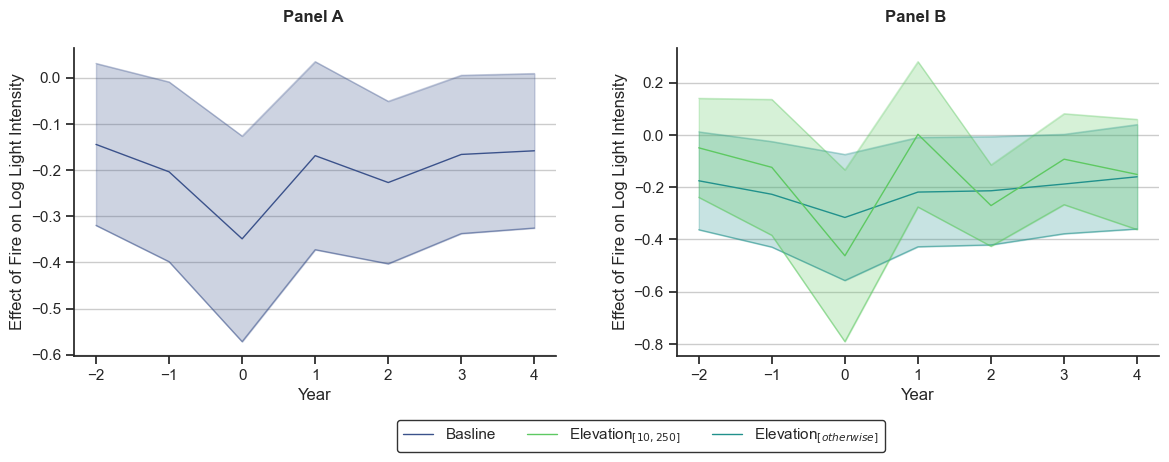

In [80]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))

colors = sns.color_palette('viridis', n_colors=3)

ax1.fill_between(x=results_df.index, y1=results_df.lower, y2=results_df.upper,
                color=colors[0], alpha=0.25)
sns.lineplot(x=results_df.index, y='lower', data = results_df,
                  linestyle='-', linewidth=1, color=colors[0], alpha=0.5, ax=ax1)
sns.lineplot(x=results_df.index, y='upper', data = results_df,
                  linestyle='-', linewidth=1, color=colors[0], alpha=0.25, ax=ax1)
sns.lineplot(x=results_df.index, y='params', data = results_df,
                  linestyle='-', linewidth=1, color=colors[0], ax=ax1, 
             label='Basline', legend=False)

ax1.set_ylabel('Effect of Fire on Log Light Intensity')
ax1.set_xlabel('Year')
ax1.yaxis.grid(True)
#ax1.set_yticks(np.arange(-0.003,0.0035,0.001))

ax2.fill_between(x=results_elevation_rest.index, y1=results_elevation_rest.lower, y2=results_elevation_rest.upper,
                color=colors[1], alpha=0.25)
sns.lineplot(x=results_elevation_rest.index, y='lower', data = results_elevation_rest,
                  linestyle='-', linewidth=1, color=colors[1], alpha=0.5, ax=ax2)
sns.lineplot(x=results_elevation_rest.index, y='upper', data = results_elevation_rest,
                  linestyle='-', linewidth=1, color=colors[1], alpha=0.25, ax=ax2)
sns.lineplot(x=results_elevation_rest.index, y='params', data = results_elevation_rest,
                  linestyle='-', linewidth=1, color=colors[1], ax=ax2, 
             label='Elevation$_{[otherwise]}$', legend=False)

ax2.fill_between(x=results_elevation_250.index, y1=results_elevation_250.lower, y2=results_elevation_250.upper,
                color=colors[2], alpha=0.25)
sns.lineplot(x=results_elevation_250.index, y='lower', data = results_elevation_250,
                  linestyle='-', linewidth=1, color=colors[2], alpha=0.5, ax=ax2, legend=False)
sns.lineplot(x=results_elevation_250.index, y='upper', data = results_elevation_250,
                  linestyle='-', linewidth=1, color=colors[2], alpha=0.25, ax=ax2, legend=False)
sns.lineplot(x=results_elevation_250.index, y='params', data = results_elevation_250,
                  linestyle='-', linewidth=1, color=colors[2], ax=ax2, 
             label='Elevation$_{[10, 250]}$', legend=False)

ax2.set_ylabel('Effect of Fire on Log Light Intensity')
ax2.set_xlabel('Year')
ax2.yaxis.grid(True)
#ax2.set_yticks(np.arange(-0.003,0.0035,0.001))

ax1.set_title('Panel A \n', fontweight='bold')
ax2.set_title('Panel B \n', fontweight='bold')

plt.subplots_adjust(wspace=0.25)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2[::-1], labels1 + labels2[::-1], loc='lower left', ncol=3, 
           edgecolor='black', bbox_to_anchor=(0.35,-0.15))

#plt.show()
plt.savefig(
   os.path.join(os.path.dirname("__file__"), '..', 'outputs', 'Heterogeneity_Elevation.png'), dpi=(150)
)

---

### Figure: Recovery Existing vs New

In [81]:
raw_df_subset['light1992_city'] = raw_df_subset.groupby('grump_URBID').light1992.transform('mean')
#raw_df_subset.groupby(['grid_cell']).light1992_city.transform('mean').describe()
raw_df_subset['light1992_city'].describe()

count    308086.000000
mean          4.557708
std           6.260722
min           0.000000
25%           1.000000
50%           2.000000
75%           6.000000
max          51.000000
Name: light1992_city, dtype: float64

In [82]:
## Below Median

condition = (raw_df_subset['light1992_city'] <= 2) & (raw_df_subset['light1992'].isna() == False)
raw_df_subset.loc[condition == True, 'new'] = 1
raw_df_subset.loc[condition == False, 'new'] = 0

condition = (raw_df_subset['light1992_city'] > 2) & (raw_df_subset['light1992'].isna() == False)
raw_df_subset.loc[condition == True, 'existing'] = 1
raw_df_subset.loc[condition == False, 'existing'] = 0

#raw_df_subset['new'] = raw_df_subset['new']  * raw_df_subset['elevation_250'] 
#raw_df_subset['existing'] = raw_df_subset['existing']  * raw_df_subset['elevation_250'] 

In [83]:
raw_df_subset[(raw_df_subset['burned_area'] > 0)]['light1992_city'].describe()
# Median Light Intensity 1992: 2
# Most Balanced: 2
#raw_df_subset[(raw_df_subset['burned_area'] > 0)][['new', 'existing']].sum()

count    185601.000000
mean          4.041023
std           5.723233
min           0.000000
25%           0.500000
50%           2.000000
75%           5.000000
max          51.000000
Name: light1992_city, dtype: float64

In [84]:
feature_list = ['new', 'existing']
shift_list = ['lead2', 'lead1', '', 'lag1', 'lag2', 'lag3', 'lag4']

for feature in feature_list:
    for shift_index, shift_string in zip(range(-2,5), shift_list):
        raw_df_subset['burned_city_' + str(feature) + str(shift_string)] = \
            raw_df_subset[str(feature)] * raw_df_subset['burned_area'].shift(shift_index)

In [85]:
results_new = pd.DataFrame(columns = ['params', 'lower', 'upper'])
results_existing = pd.DataFrame(columns = ['params', 'lower', 'upper'])

shift_list = ['lead2', 'lead1', '', 'lag1', 'lag2', 'lag3', 'lag4']

for shift_string in shift_list:
    condition = (raw_df_subset['burned_area'] > 0)
    data_regression = raw_df_subset[condition]

    # Set target 
    target = ['ln_light']
    
    # Set features
    bin_list = ['new', 'existing']
    
    features = [] 
    for bin_index in bin_list:
        features += ['burned_city_' + str(bin_index) + str(shift_string)]
    
    fixed_effects = ['grump_Countryeng', 'grid_cell_area']
    
    data_regression = data_regression.dropna(subset = target + features + fixed_effects)
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
    #data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grid_cell'])
    data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
    
    Y = data_regression[target]
    X = data_regression[features]
    X = sm.add_constant(X)
    
    dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
    X = pd.concat([X, dummies], axis=1)
    
    panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
                               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
    results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
    #results = panel_ols_model.fit(cov_type='robust')
    
    results_new.loc[features[0], 'params'] = results.params[features[0]]
    results_new.loc[features[0], 'lower'] = results.conf_int(confidence_level).loc[features[0],'lower']
    results_new.loc[features[0], 'upper'] = results.conf_int(confidence_level).loc[features[0],'upper']
    
    results_existing.loc[features[1], 'params'] = results.params[features[1]]
    results_existing.loc[features[1], 'lower'] = results.conf_int(confidence_level).loc[features[1],'lower']
    results_existing.loc[features[1], 'upper'] = results.conf_int(confidence_level).loc[features[1],'upper']

In [86]:
results_new.index = np.arange(-2,5)
results_new = results_new.astype(float)

results_existing.index = np.arange(-2,5)
results_existing = results_existing.astype(float)

#### Figure

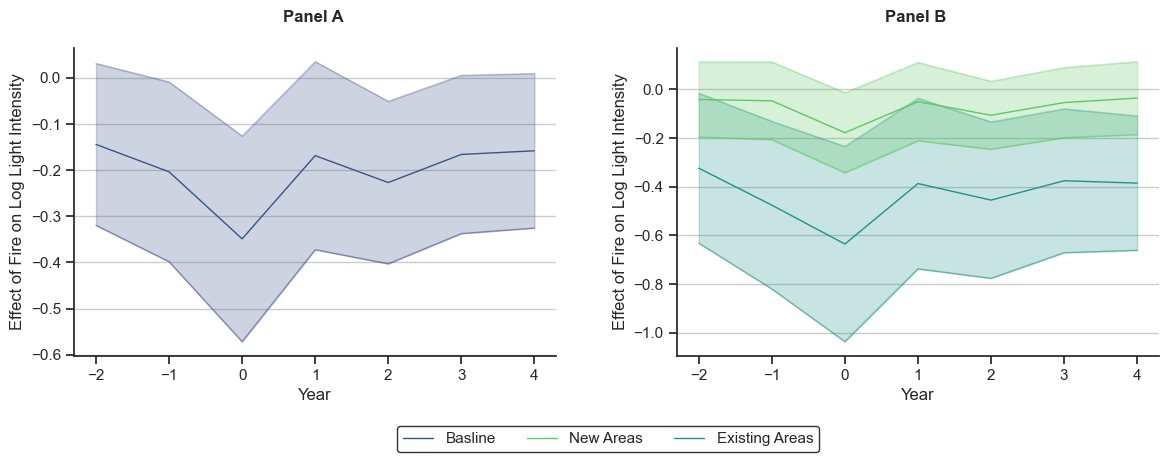

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))

colors = sns.color_palette('viridis', n_colors=3)

ax1.fill_between(x=results_df.index, y1=results_df.lower, y2=results_df.upper,
                color=colors[0], alpha=0.25)
sns.lineplot(x=results_df.index, y='lower', data = results_df,
                  linestyle='-', linewidth=1, color=colors[0], alpha=0.5, ax=ax1)
sns.lineplot(x=results_df.index, y='upper', data = results_df,
                  linestyle='-', linewidth=1, color=colors[0], alpha=0.25, ax=ax1)
sns.lineplot(x=results_df.index, y='params', data = results_df,
                  linestyle='-', linewidth=1, color=colors[0], ax=ax1, 
             label='Basline', legend=False)

ax1.set_ylabel('Effect of Fire on Log Light Intensity')
ax1.set_xlabel('Year')
ax1.yaxis.grid(True)
#ax1.set_yticks(np.arange(-0.003,0.0035,0.001))

ax2.fill_between(x=results_existing.index, y1=results_existing.lower, y2=results_existing.upper,
                color=colors[1], alpha=0.25)
sns.lineplot(x=results_existing.index, y='lower', data = results_existing,
                  linestyle='-', linewidth=1, color=colors[1], alpha=0.5, ax=ax2)
sns.lineplot(x=results_existing.index, y='upper', data = results_existing,
                  linestyle='-', linewidth=1, color=colors[1], alpha=0.25, ax=ax2)
sns.lineplot(x=results_existing.index, y='params', data = results_existing,
                  linestyle='-', linewidth=1, color=colors[1], ax=ax2, 
             label='Existing Areas', legend=False)

ax2.fill_between(x=results_new.index, y1=results_new.lower, y2=results_new.upper,
                color=colors[2], alpha=0.25)
sns.lineplot(x=results_new.index, y='lower', data = results_new,
                  linestyle='-', linewidth=1, color=colors[2], alpha=0.5, ax=ax2, legend=False)
sns.lineplot(x=results_new.index, y='upper', data = results_new,
                  linestyle='-', linewidth=1, color=colors[2], alpha=0.25, ax=ax2, legend=False)
sns.lineplot(x=results_new.index, y='params', data = results_new,
                  linestyle='-', linewidth=1, color=colors[2], ax=ax2, 
             label='New Areas', legend=False)

#ax2.errorbar(x=results_new.index, y=results_new.params, 
#             yerr=[results_new.lower - results_new.params], 
#             color='red', alpha=0.75, capsize=5, markeredgewidth=1, marker='o')

ax2.set_ylabel('Effect of Fire on Log Light Intensity')
ax2.set_xlabel('Year')
ax2.yaxis.grid(True)
#ax2.set_yticks(np.arange(-0.003,0.0035,0.001))

ax1.set_title('Panel A \n', fontweight='bold')
ax2.set_title('Panel B \n', fontweight='bold')

plt.subplots_adjust(wspace=0.25)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2[::-1], labels1 + labels2[::-1], loc='lower left', ncol=3, 
           edgecolor='black', bbox_to_anchor=(0.35,-0.15))

#plt.show()
plt.savefig(
   os.path.join(os.path.dirname("__file__"), '..', 'outputs', 'Heterogeneity_New_Existing.png'), dpi=(150)
)

## 3. Regression: Wildfire x Determinants
## 4. Regressions: Light x Wildfire Lags 
## 5. Regressions: Light x Wildfire Interaction Lags

#### Final Figures

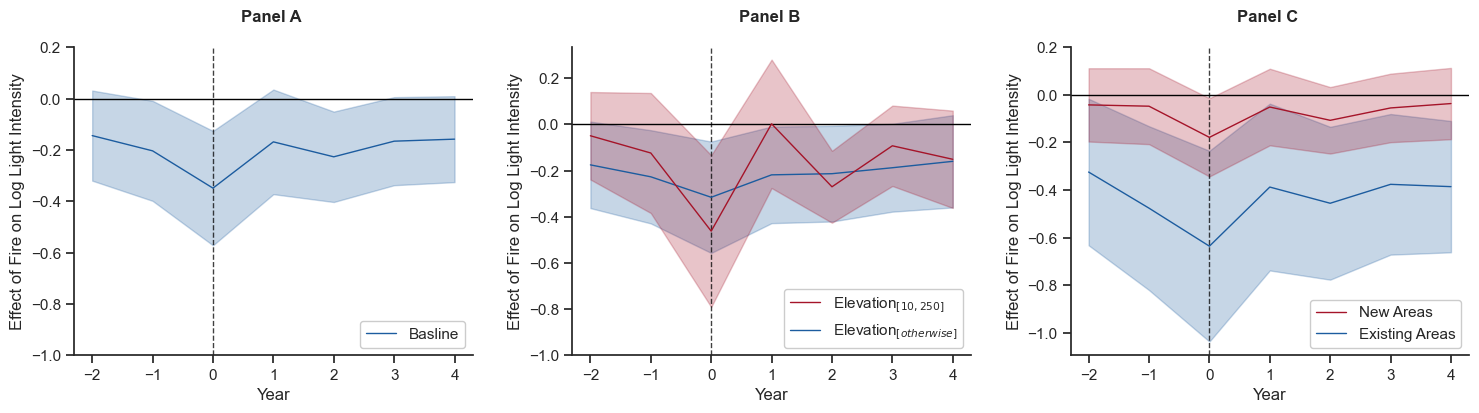

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 4))

#colors = sns.color_palette('viridis', n_colors=3)
colors = sns.color_palette('RdBu_r', n_colors=11)

ax1.axhline(y = 0, color = 'black', linestyle = '-', alpha=1, linewidth=1)
ax2.axhline(y = 0, color = 'black', linestyle = '-', alpha=1, linewidth=1)
ax3.axhline(y = 0, color = 'black', linestyle = '-', alpha=1, linewidth=1)

ax1.axvline(x = 0, color = 'black', linestyle = '--', alpha=0.75, linewidth=1)
ax2.axvline(x = 0, color = 'black', linestyle = '--', alpha=0.75, linewidth=1)
ax3.axvline(x = 0, color = 'black', linestyle = '--', alpha=0.75, linewidth=1)

ax1.fill_between(x=results_df.index, y1=results_df.lower, y2=results_df.upper,
                color=colors[0], alpha=0.25)
#sns.lineplot(x=results_df.index, y='lower', data = results_df,
#                  linestyle='-', linewidth=1, color=colors[0], alpha=0.5, ax=ax1)
#sns.lineplot(x=results_df.index, y='upper', data = results_df,
#                  linestyle='-', linewidth=1, color=colors[0], alpha=0.25, ax=ax1)
sns.lineplot(x=results_df.index, y='params', data = results_df,
                  linestyle='-', linewidth=1, color=colors[0], ax=ax1, 
             label='Basline', legend=True)

ax1.set_ylabel('Effect of Fire on Log Light Intensity')
ax1.set_xlabel('Year')
#ax1.yaxis.grid(True)
ax1.set_yticks(np.arange(-1,0.4,0.2))
#ax1.set_yticks(np.arange(-0.7,0.6,0.2)) # Grid-Cell FE

ax2.fill_between(x=results_elevation_rest.index, y1=results_elevation_rest.lower, y2=results_elevation_rest.upper,
                color=colors[0], alpha=0.25)
#sns.lineplot(x=results_elevation_rest.index, y='lower', data = results_elevation_rest,
#                  linestyle='-', linewidth=1, color=colors[1], alpha=0.5, ax=ax2)
#sns.lineplot(x=results_elevation_rest.index, y='upper', data = results_elevation_rest,
#                  linestyle='-', linewidth=1, color=colors[1], alpha=0.25, ax=ax2)
sns.lineplot(x=results_elevation_rest.index, y='params', data = results_elevation_rest,
                  linestyle='-', linewidth=1, color=colors[0], ax=ax2, 
             label='Elevation$_{[otherwise]}$', legend=True)

ax2.fill_between(x=results_elevation_250.index, y1=results_elevation_250.lower, y2=results_elevation_250.upper,
                color=colors[10], alpha=0.25)
#sns.lineplot(x=results_elevation_250.index, y='lower', data = results_elevation_250,
#                  linestyle='-', linewidth=1, color=colors[2], alpha=0.5, ax=ax2, legend=False)
#sns.lineplot(x=results_elevation_250.index, y='upper', data = results_elevation_250,
#                  linestyle='-', linewidth=1, color=colors[2], alpha=0.25, ax=ax2, legend=False)
sns.lineplot(x=results_elevation_250.index, y='params', data = results_elevation_250,
                  linestyle='-', linewidth=1, color=colors[10], ax=ax2, 
             label='Elevation$_{[10, 250]}$', legend=True)

ax2.set_ylabel('Effect of Fire on Log Light Intensity')
ax2.set_xlabel('Year')
#ax2.yaxis.grid(True)
ax2.set_yticks(np.arange(-1,0.4,0.2))
#ax2.set_yticks(np.arange(-0.7,0.6,0.2)) # Grid-Cell FE

##################################################

ax3.fill_between(x=results_existing.index, y1=results_existing.lower, y2=results_existing.upper,
                color=colors[0], alpha=0.25)
#sns.lineplot(x=results_existing.index, y='lower', data = results_existing,
#                  linestyle='-', linewidth=1, color=colors[1], alpha=0.5, ax=ax3)
#sns.lineplot(x=results_existing.index, y='upper', data = results_existing,
#                  linestyle='-', linewidth=1, color=colors[1], alpha=0.25, ax=ax3)
sns.lineplot(x=results_existing.index, y='params', data = results_existing,
                  linestyle='-', linewidth=1, color=colors[0], ax=ax3, 
             label='Existing Areas', legend=True)

ax3.fill_between(x=results_new.index, y1=results_new.lower, y2=results_new.upper,
                color=colors[10], alpha=0.25)
#sns.lineplot(x=results_new.index, y='lower', data = results_new,
#                  linestyle='-', linewidth=1, color=colors[2], alpha=0.5, ax=ax3, legend=False)
#sns.lineplot(x=results_new.index, y='upper', data = results_new,
#                  linestyle='-', linewidth=1, color=colors[2], alpha=0.25, ax=ax3, legend=False)
sns.lineplot(x=results_new.index, y='params', data = results_new,
                  linestyle='-', linewidth=1, color=colors[10], ax=ax3, 
             label='New Areas', legend=True)

ax3.set_ylabel('Effect of Fire on Log Light Intensity')
ax3.set_xlabel('Year')
#ax3.yaxis.grid(True)
ax3.set_yticks(np.arange(-1,0.4,0.2))
#ax3.set_yticks(np.arange(-0.7,0.6,0.2)) # Grid-Cell FE

##################################################

ax1.set_title('Panel A \n', fontweight='bold')
ax2.set_title('Panel B \n', fontweight='bold')
ax3.set_title('Panel C \n', fontweight='bold')

ax1.legend(edgecolor='0.8', loc='lower right', framealpha=1)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], edgecolor='0.8', loc='lower right', framealpha=1)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles[::-1], labels[::-1], edgecolor='0.8', loc='lower right', framealpha=1)

plt.subplots_adjust(wspace=0.25)

#plt.show()
plt.savefig(
   os.path.join(os.path.dirname("__file__"), '..', 'outputs', 'Heterogeneity_Burned_Area_City.png'), dpi=(150)
)

## 3. Regression: Wildfire x Determinants
## 4. Regressions: Light x Wildfire Lags 
## 5. Regressions: Light x Wildfire Interaction Lags

In [89]:
results_existing

,params,lower,upper
-2,-0.324078,-0.631705,-0.016451
-1,-0.475759,-0.819721,-0.131796
0,-0.635432,-1.036006,-0.234858
1,-0.387137,-0.737336,-0.036937
2,-0.455152,-0.776046,-0.134259
3,-0.375697,-0.670944,-0.080450
4,-0.385394,-0.661094,-0.109694


In [90]:
# https://stackoverflow.com/questions/24195432/fixed-effect-in-pandas-or-statsmodels

---

## 6. Regressions: Change in Land Use

Differences in Land Use between years
elevation 250 x new vs existing

---

In [91]:
## Relative cells affected

display((raw_df_subset[landuse_features_change] > 0).sum() / (raw_df_subset[landuse_features_change] >= 0).sum())
display(raw_df_subset[landuse_features_change].describe())

urban_change              0.121305
cropland_change           0.233965
pasture_change            0.173752
forest_change             0.261849
grass_shrubland_change    0.213258
other_land_change         0.029396
ocean_change              0.000000
water_change              0.000000
dtype: float64

,urban_change,cropland_change,pasture_change,forest_change,grass_shrubland_change,other_land_change,ocean_change,water_change
count,308086.000000,308086.000000,308086.000000,308086.000000,308086.000000,308086.000000,308086.0,308086.0
mean,0.000297,-0.000474,-0.000307,0.000486,0.000089,-0.000092,0.0,0.0
std,0.002142,0.011982,0.009635,0.005933,0.009923,0.004527,0.0,0.0
min,-0.153600,-0.361600,-0.443200,-0.190400,-0.513600,-0.385600,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,0.142400,0.468800,0.510400,0.302400,0.443200,0.264000,0.0,0.0


In [92]:
landuse_features_change_copy = raw_df_subset[landuse_features_change]
raw_df_subset[landuse_features_change] = landuse_features_change_copy

In [93]:
## Group cultivated and uncultivated land categories

raw_df_subset['cultivated_land_change'] = raw_df_subset[['cropland_change', 'pasture_change']].sum(axis=1)
raw_df_subset['uncultivated_land_change'] = raw_df_subset[['forest_change', 'grass_shrubland_change']].sum(axis=1)

In [94]:
raw_df_subset[['urban_change', 'cultivated_land_change', 'uncultivated_land_change']].describe()

,urban_change,cultivated_land_change,uncultivated_land_change
count,308086.000000,308086.000000,308086.000000
mean,0.000297,-0.000781,0.000575
std,0.002142,0.011547,0.010753
min,-0.153600,-0.443200,-0.513600
25%,0.000000,-0.001600,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.001600
max,0.142400,0.510400,0.443200


In [95]:
#raw_df_subset['urban_change_city'] = raw_df_subset.groupby(['grump_URBID', 'grid_year'])['urban_change'].transform('max')
#raw_df_subset['urban_change_frequency'] = raw_df_subset.groupby(['grid_cell']).urban_change_city.transform('mean')
#raw_df_subset['frequency'].describe()

In [96]:
#raw_df_subset[landuse_features_change] *= 100

raw_df_subset.loc[raw_df_subset['cultivated_land_change'] > 0, 'cultivated_land_change'] = 1
raw_df_subset.loc[raw_df_subset['cultivated_land_change'] < 0, 'cultivated_land_change'] = -1
raw_df_subset.loc[raw_df_subset['uncultivated_land_change'] > 0, 'uncultivated_land_change'] = 1
raw_df_subset.loc[raw_df_subset['uncultivated_land_change'] < 0, 'uncultivated_land_change'] = -1

for feature in landuse_features_change:
    raw_df_subset.loc[raw_df_subset[feature] > 0, feature] = 1
    raw_df_subset.loc[raw_df_subset[feature] < 0, feature] = -1

In [97]:
## Create Lags of Burned Area

# raw_df_subset['burned_city_standard'] = (raw_df_subset['burned_area_city'] - raw_df_subset['burned_area_city'].mean() ) / raw_df_subset['burned_area_city'].std()

raw_df_subset['burned_city_lag1'] = raw_df_subset['burned_area'].shift(1)
raw_df_subset['burned_city_lag2'] = raw_df_subset['burned_area'].shift(2)
raw_df_subset['burned_city_lag3'] = raw_df_subset['burned_area'].shift(3)
raw_df_subset['burned_city_lag4'] = raw_df_subset['burned_area'].shift(4)
raw_df_subset['burned_city_lag5'] = raw_df_subset['burned_area'].shift(5)
raw_df_subset['burned_city_lag6'] = raw_df_subset['burned_area'].shift(6)

---

In [98]:
# https://stackoverflow.com/questions/24195432/fixed-effect-in-pandas-or-statsmodels

condition = (raw_df_subset['burned_area'] > 0) # or burned_area, burned_area_city
data_regression = raw_df_subset[condition]

# Set target 
target = ['urban_change'] # probability of more or less
# ['urban_change', 'cultivated_land_change', 'uncultivated_land_change']
# ['urban_change','cropland_change','pasture_change','forest_change','grass_shrubland_change',

# Set features
features = ['burned_area'] 
# elevation_250_burned
# burned_area # burned_city_lag1

#features += ['urban', 'cropland', 'pasture', 'forest', 'grass_shrubland']
                       
fixed_effects = ['grump_Countryeng', 'grid_cell_area']

data_regression = data_regression.dropna(subset = target + features + fixed_effects)
data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
#data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes

#data_regression['grump_NAME'] = data_regression['grump_NAME'].astype('category')
#data_regression['grump_NAME'] = data_regression['grump_NAME'].cat.codes
#data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grid_cell'])
data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
    
Y = data_regression[target]
X = data_regression[features]
X = sm.add_constant(X)

dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
X = pd.concat([X, dummies], axis=1)

In [99]:
panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
               entity_effects=True, time_effects=False, check_rank=False, drop_absorbed=True)
results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
#results = panel_ols_model.fit(cov_type='robust')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:           urban_change   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -0.0017
No. Observations:              185601   R-squared (Within):               0.0005
Date:                Wed, Jan 31 2024   R-squared (Overall):              0.0004
Time:                        13:34:29   Log-likelihood                  -6.8e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      31.310
Entities:                         184   P-value                           0.0000
Avg Obs:                       1008.7   Distribution:                F(6,185411)
Min Obs:                       1.0000                                           
Max Obs:                      2.9e+04   F-statistic (robust):             3.9447
                            

---

#### Recovery

In [100]:
#### Loop

feature_list = ['burned_area', 'burned_city_lag1', 'burned_city_lag2', 'burned_city_lag3', 'burned_city_lag4']
#feature_list = ['count', 'count_city_lag1', 'count_city_lag2', 'count_city_lag3', 'count_city_lag4']
#feature_list = ['elevation_250_burned', 'elevation_250_burnedlag1', 'elevation_250_burnedlag2', 
#                'elevation_250_burnedlag3', 'elevation_250_burnedlag4']

regression_change_results = pd.DataFrame(columns=['params' , 'std_errors', 'pvalues'])

for index in feature_list:
    condition = (raw_df_subset['burned_area'] > 0) # or burned_area, burned_area_city
    data_regression = raw_df_subset[condition]

    target = ['urban_change'] 
    # ['urban_change', 'cultivated_land_change', 'uncultivated_land_change']
    # ['urban_change','cropland_change','pasture_change','forest_change','grass_shrubland_change',

    features = [index]
                       
    fixed_effects = ['grump_Countryeng', 'grid_cell_area']

    data_regression = data_regression.dropna(subset = target + features + fixed_effects)
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
    #data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grid_cell'])
    data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
    
    Y = data_regression[target]
    X = data_regression[features]
    X = sm.add_constant(X)

    dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
    X = pd.concat([X, dummies], axis=1)
    
    panel_ols_model = PanelOLS(Y, X, weights=data_regression['grid_cell_area'], 
                               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
    results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
    #results = panel_ols_model.fit(cov_type='robust')
    
    regression_change_results.loc[index, 'params'] = np.round(results.params[1:2].values[0],4)
    regression_change_results.loc[index, 'std_errors'] = np.round(results.std_errors[1:2].values[0],4)
    regression_change_results.loc[index, 'pvalues'] = np.round(results.pvalues[1:2].values[0],4)

In [101]:
display(regression_change_results)

,params,std_errors,pvalues
burned_area,-0.0739,0.041,0.0717
burned_city_lag1,-0.0682,0.0329,0.0383
burned_city_lag2,-0.0639,0.0334,0.0559
burned_city_lag3,-0.108,0.0319,0.0007
burned_city_lag4,-0.0363,0.0304,0.2329


---

In [102]:
condition = (raw_df_subset['burned_area'] > 0) # or burned_area, burned_area_city
data_regression = raw_df_subset[condition]
round(data_regression['burned_area'].std(),2) * -0.0018

-7.199999839067459e-05

---

#### Heterogeneity: New vs Existing

Add Figure

In [103]:
results_new = pd.DataFrame(columns = ['params', 'std_errors', 'pvalues'])
results_existing = pd.DataFrame(columns = ['params', 'std_errors', 'pvalues'])

shift_list = ['lead2', 'lead1', '', 'lag1', 'lag2', 'lag3', 'lag4']

for shift_string in shift_list:
    condition = (raw_df_subset['burned_area'] > 0)
    data_regression = raw_df_subset[condition]

    # Set target 
    target = ['uncultivated_land_change']
    
    # Set features
    bin_list = ['new', 'existing']
    
    features = [] 
    for bin_index in bin_list:
        features += ['burned_city_' + str(bin_index) + str(shift_string)]
    
    fixed_effects = ['grump_Countryeng', 'grid_cell_area']
    
    data_regression = data_regression.dropna(subset = target + features + fixed_effects)
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].astype('category')
    data_regression['grump_Countryeng'] = data_regression['grump_Countryeng'].cat.codes
    #data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grid_cell'])
    data_regression = data_regression.reset_index().set_index(['grump_Countryeng', 'grump_URBID'])
    
    Y = data_regression[target]
    X = data_regression[features]
    X = sm.add_constant(X)
    
    dummies = pd.get_dummies(data=data_regression['grid_year'], drop_first=True)
    X = pd.concat([X, dummies], axis=1)
    
    panel_ols_model = PanelOLS(Y, X, #weights=data_regression['grid_cell_area'], 
                               entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
    results = panel_ols_model.fit(cov_type='clustered', cluster_entity=True)
    #results = panel_ols_model.fit(cov_type='robust')
    
    results_new.loc[features[0], 'params'] = results.params[features[0]]
    results_new.loc[features[0], 'std_errors'] = results.std_errors[features[1]]
    results_new.loc[features[0], 'pvalues'] = results.pvalues[features[1]]
    
    results_existing.loc[features[1], 'params'] = results.params[features[1]]
    results_existing.loc[features[1], 'std_errors'] = results.std_errors[features[1]]
    results_existing.loc[features[1], 'pvalues'] = results.pvalues[features[1]]

In [104]:
display(results_new)
display(results_existing)

,params,std_errors,pvalues
burned_city_newlead2,0.071239,0.127689,0.270807
burned_city_newlead1,-0.004312,0.119991,0.625991
burned_city_new,-0.148051,0.141042,0.198884
burned_city_newlag1,-0.053208,0.116115,0.888641
burned_city_newlag2,-0.151686,0.128259,0.282737
burned_city_newlag3,-0.101374,0.103834,0.669199
burned_city_newlag4,0.066888,0.120561,0.671326


,params,std_errors,pvalues
burned_city_existinglead2,0.140612,0.127689,0.270807
burned_city_existinglead1,-0.058481,0.119991,0.625991
burned_city_existing,-0.181203,0.141042,0.198884
burned_city_existinglag1,-0.016259,0.116115,0.888641
burned_city_existinglag2,-0.137775,0.128259,0.282737
burned_city_existinglag3,-0.044363,0.103834,0.669199
burned_city_existinglag4,0.051158,0.120561,0.671326


---

## 7. Regressions: Robustness IV

In [105]:
from linearmodels import PanelOLS, PooledOLS, RandomEffects, IV2SLS, IVGMM

In [106]:
target = ['ln_light']
exogenous = ['burned_area'] # burned_area # burned_city_lag1
endogenous = ['ln_light_lag1']
instrument = ['ln_light_lag2']
fixed_effects = ['year', 'cell', 'grump_Countryeng', 'grump_URBID']

condition = (raw_df_subset['burned_area'] > 0)
data_regression = raw_df_subset.dropna(subset = target + exogenous + endogenous + instrument + fixed_effects)

Y = data_regression[target]
X = data_regression[exogenous]
X = sm.add_constant(X)

data_regression['year'] = 'year_' + data_regression['year'].astype(str)
dummies = pd.get_dummies(data=data_regression['year'], drop_first=True)
X = pd.concat([X, dummies], axis=1)

dummies = pd.get_dummies(data=data_regression['grump_Countryeng'], drop_first=True)
X = pd.concat([X, dummies], axis=1)

W = data_regression[endogenous]
Z = data_regression[instrument]

In [107]:
resultIV = IV2SLS(Y, X, W, Z, weights=data_regression['grid_cell_area'])
results = resultIV.fit(cov_type="clustered", clusters=data_regression['grump_Countryeng'])
#results = resultIV.fit(cov_type='unadjusted')
print(results)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               ln_light   R-squared:                      0.5504
Estimator:                    IV-2SLS   Adj. R-squared:                 0.5501
No. Observations:              308086   F-statistic:                -6.285e+19
Date:                Wed, Jan 31 2024   P-value (F-stat)                1.0000
Time:                        13:37:21   Distribution:                chi2(208)
Cov. Estimator:             clustered                                         
                                                                              
                                         Parameter Estimates                                         
                                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------------
const                                 0.2372     0.0140     16

---